In [1]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/hrithikppawar/Face-Mask-Detection-Using-VGG16/blob/main/Face_Mask_Detection_VGG16.ipynb 

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import models
from sklearn.metrics import classification_report, confusion_matrix
import pathlib

In [2]:
data_train = pathlib.Path('./Dataset/train')
data_test = pathlib.Path('./Dataset/test')

INPUT_SIZE = [300, 300]
BATCH = 6

In [16]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.0,
    # rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

training_data = training_datagen.flow_from_directory('./Dataset/train',
                                                     subset="training",
                                                     shuffle=True,
                                                     target_size=INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     color_mode="rgb",
                                                     class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255, 
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input

)

test_data = test_datagen.flow_from_directory('./Dataset/test',
                                             target_size=INPUT_SIZE,
                                             color_mode="rgb",
                                             batch_size=BATCH,
                                             class_mode='categorical',
                                             shuffle=False)

# display dimensions
x_test, y_test = next(test_data)
x_train, y_train = next(training_data)

Found 1956 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


In [17]:
vgg_model = tf.keras.applications.VGG16(input_shape=(300, 300, 3), include_top=False, weights='imagenet')
vgg_model.trainable = True

fine_tune_at = 100
for layer in vgg_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

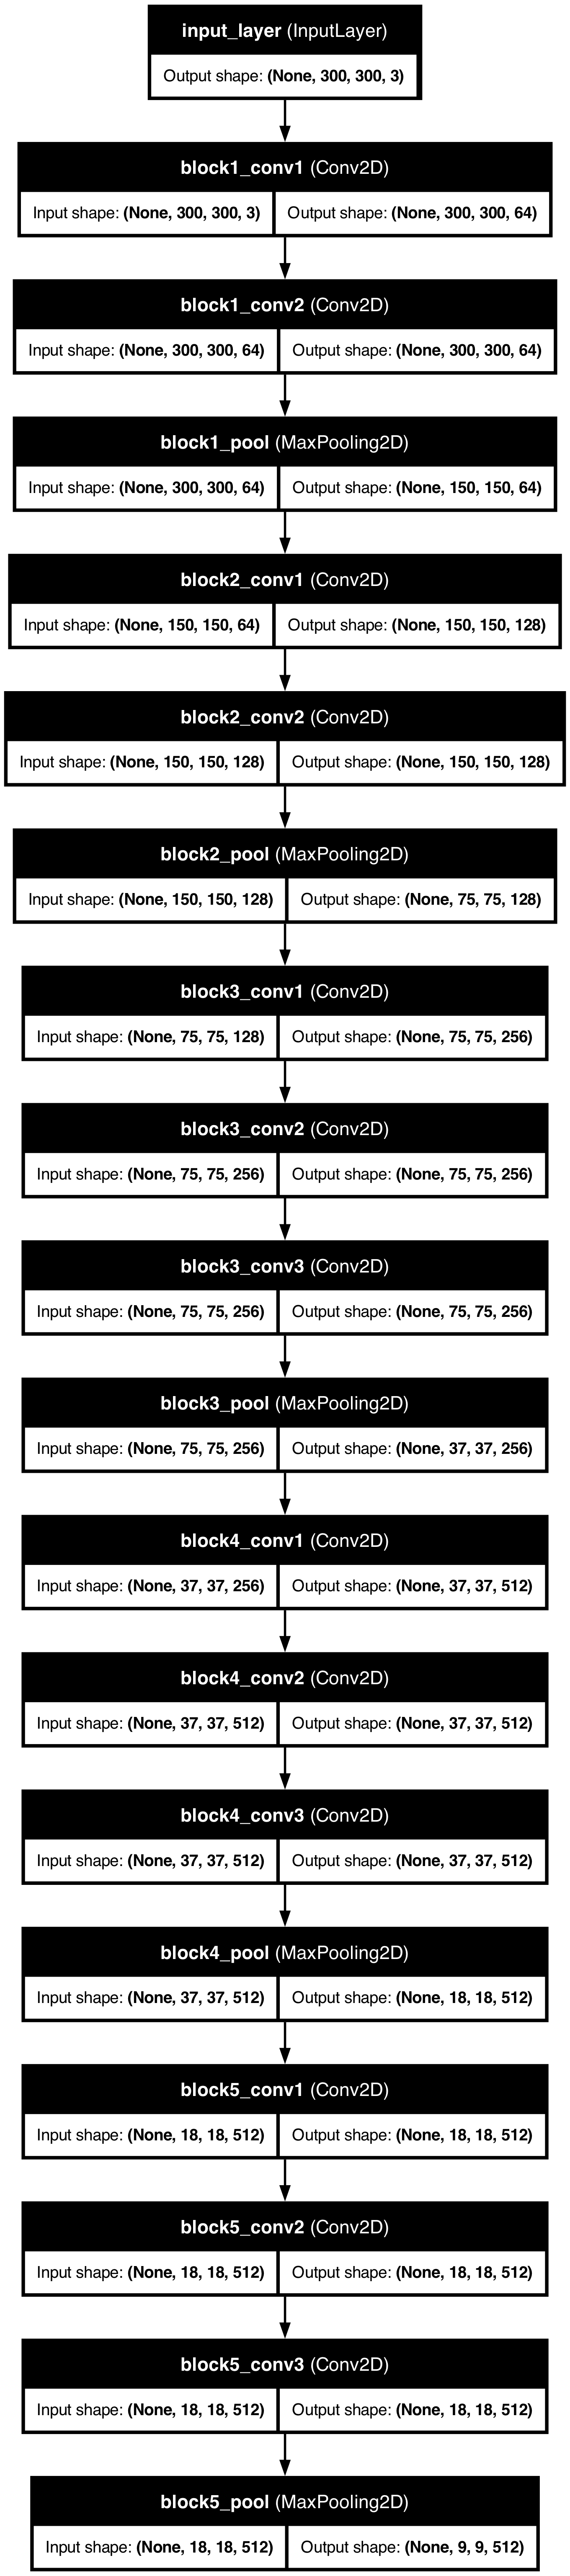

In [5]:
import tensorflow as tf

tf.keras.utils.plot_model(vgg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


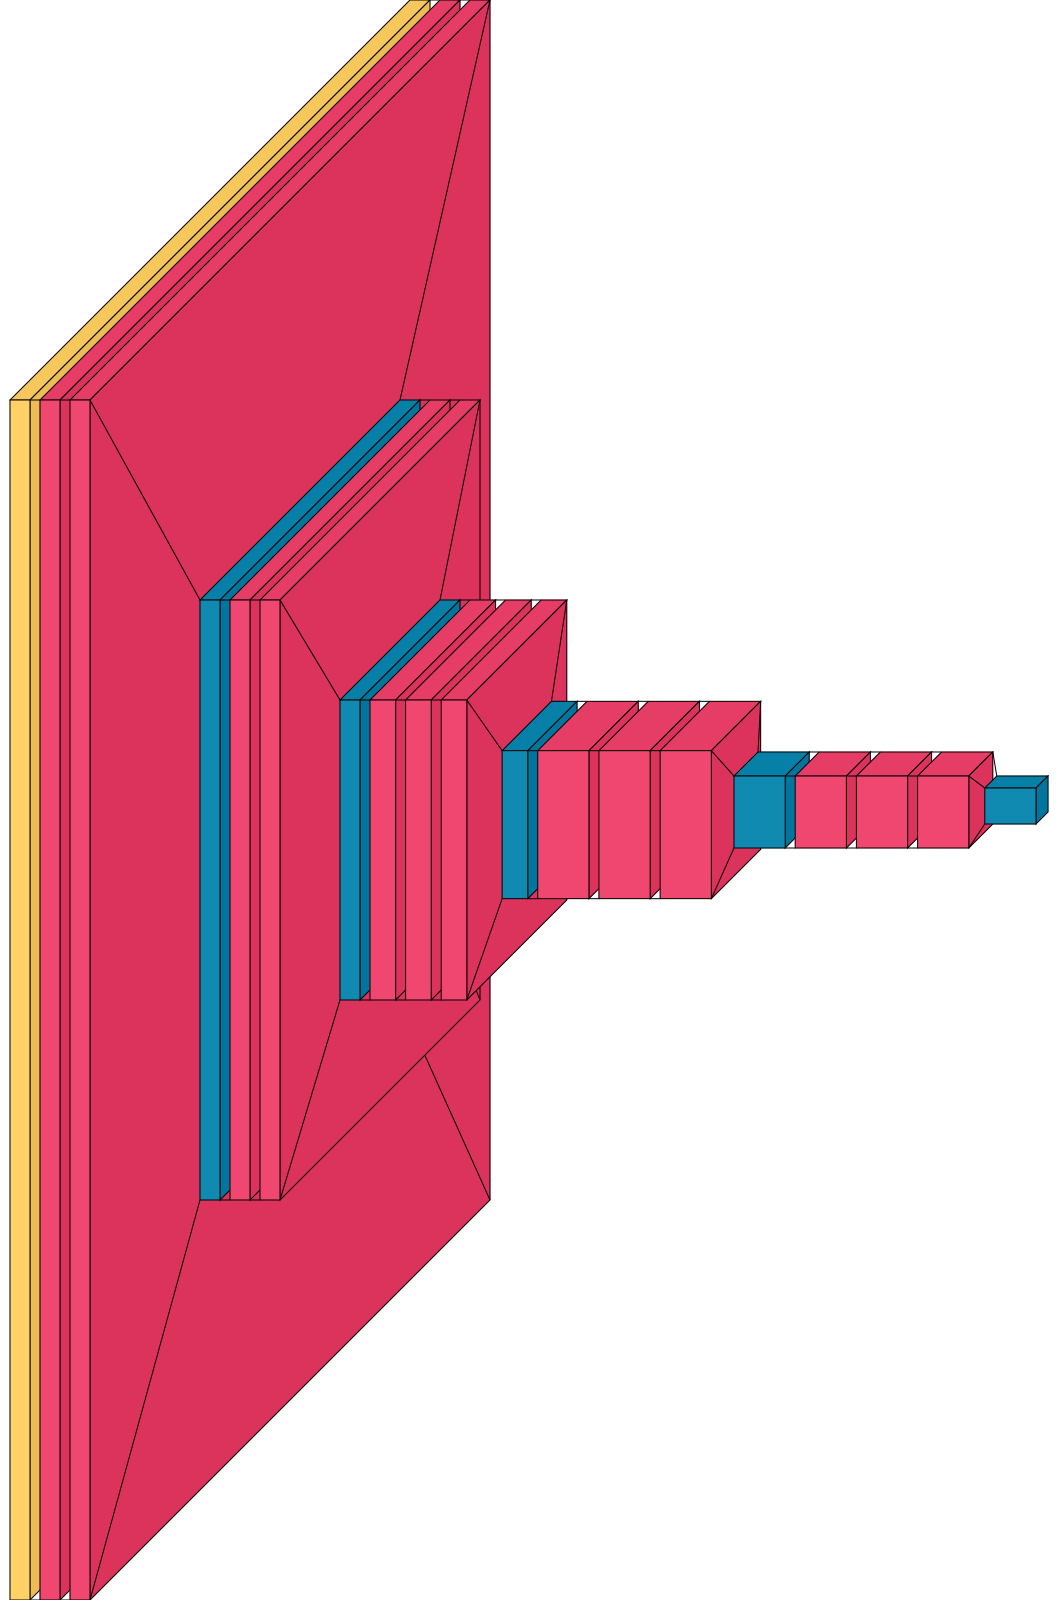

In [6]:
import visualkeras

visualkeras.layered_view(vgg_model)

In [26]:
# flatten = Flatten()(vgg_model.output)
# dense_1 = Dense(units=500, activation='relu')(flatten)
# dense_2 = Dense(units=400, activation='relu')(dense_1)
# dense_3 = Dense(units=300, activation='relu')(dense_2)
# dense_4 = Dense(units=100, activation='relu')(dense_3)
# dense_output = Dense(units=5, activation='softmax')(dense_4)
# 
# model = models.Model(inputs=vgg_model.input, outputs=dense_output)
# model.summary()

model = models.Sequential()
model.add(tf.keras.layers.InputLayer((300, 300, 3)))
model.add(vgg_model)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

for layer in vgg_model.layers[:15]:
    layer.trainable = False

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 9, 9, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

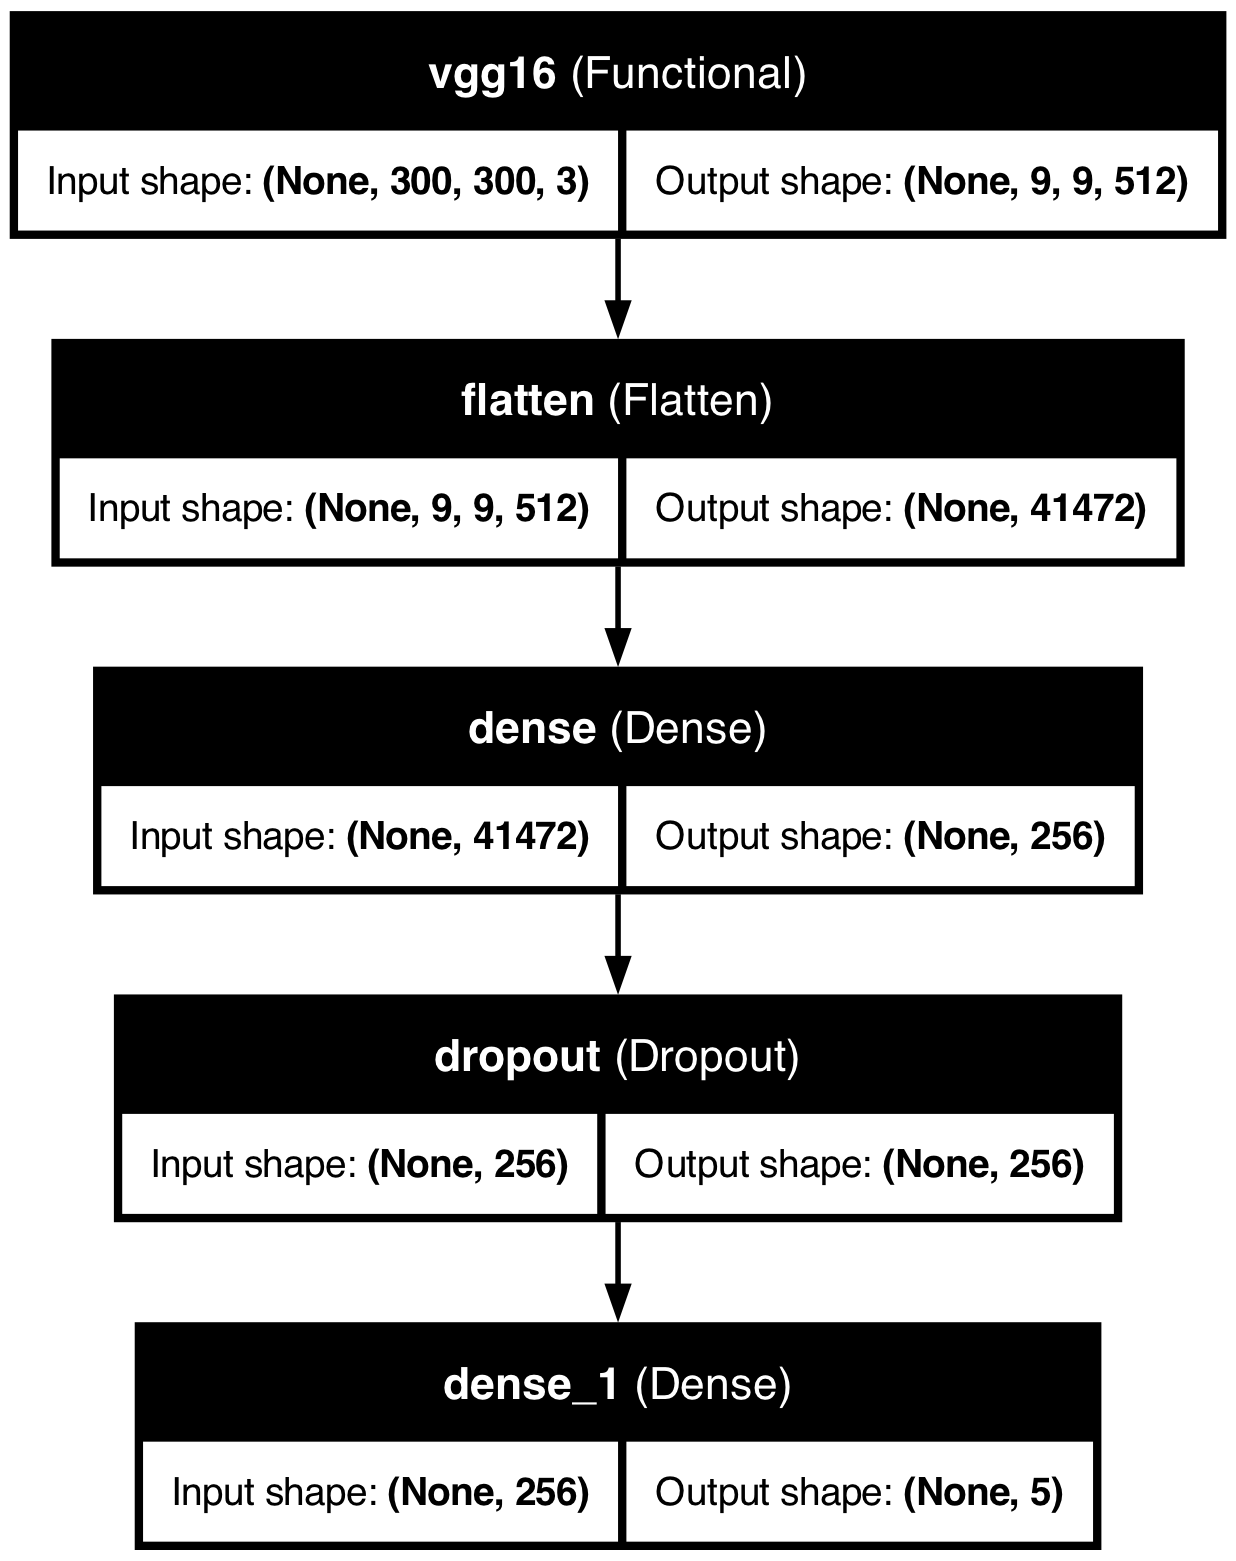

In [8]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

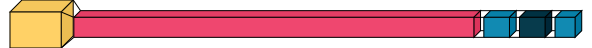

In [9]:
visualkeras.layered_view(model)

In [27]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
#  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
# sparse_categorical_crossentropy

history = model.fit(
    training_data,
    validation_data=test_data,
    epochs=5,
    # batch_size=BATCH,
    # steps_per_epoch=len(training_data),
    # validation_steps=len(test_data)
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 292s 891ms/step - accuracy: 0.6178 - loss: 1.9135 - val_accuracy: 0.7667 - val_loss: 0.6377
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 284s 869ms/step - accuracy: 0.8248 - loss: 0.4730 - val_accuracy: 0.8152 - val_loss: 0.5612
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 273s 837ms/step - accuracy: 0.8186 - loss: 0.5086 - val_accuracy: 0.8545 - val_loss: 0.4064
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 273s 836ms/step - accuracy: 0.8696 - loss: 0.3617 - val_accuracy: 0.8364 - val_loss: 0.4875
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 275s 843ms/step - accuracy: 0.8722 - loss: 0.3468 - val_accuracy: 0.7970 - val_loss: 0.5937


In [28]:
# create confusion matrix
y_pred=model.predict(test_data, batch_size=BATCH)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm=confusion_matrix(test_data.classes, y_pred)
print(cm)

#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)

#Reporte de metricas
# target_names = ['cloth', 'n95', 'n95v', 'nfm', 'srg']
# print(classification_report(test_data.classes, y_pred, target_names=target_names, digits=4))

# loss, accuracy, specificity, precision, recall = model.evaluate(test_data, verbose=0)
loss, accuracy = model.evaluate(test_data, verbose=0)
print(loss, accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 857ms/step
(330, 5)
[0 0 0 0 0 0 0 0 1 0 0 0 3 0 1 0 0 0 1 0 0 1 0 1 0 4 0 0 0 0 0 1 1 0 0 1 0
 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 4 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 1 2 1 4 2
 2 2 2 1 2 2 2 2 1 2 2 1 2 2 2 1 1 1 2 2 2 2 2 1 2 2 1 2 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 4 1 0 4 1 1 4 1 1 1 1 4 0 4 1 1 4 4 4 1 4 1 4 4 1 1 1 4 1 1 4 4
 4 4 0 4 4 0 4 4 0 4 4 4 1 1 0 4 4 4 1 4 1 4 1 4 4 4 4 4 4 1 1 4 4 4]
[[58 17  0  1  2]
 [ 0 48  1  0  1]
 [ 0 14 34  0  1]
 [ 1  0  0 77  0]
 [ 6 23  0  0 46]]
[0.74358974 0.96       0.69387755 0.98717949 0.61333333]
0.5937431454658508 0.7969697117805481


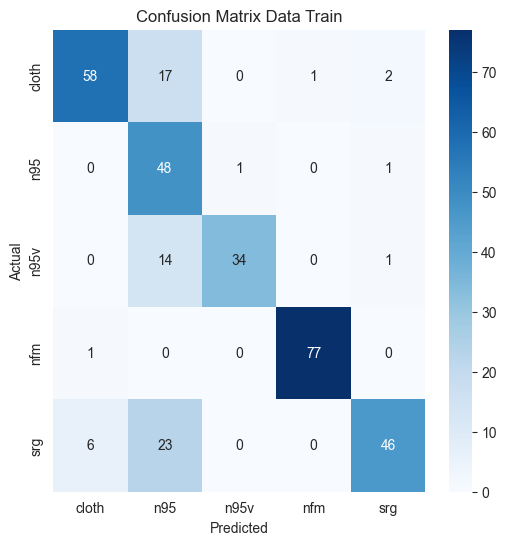

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['cloth', 'n95', 'n95v', 'nfm', 'srg'], yticklabels=['cloth', 'n95', 'n95v', 'nfm', 'srg'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Train')
plt.show()

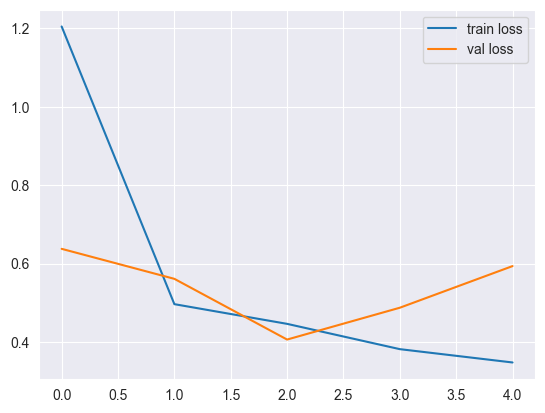

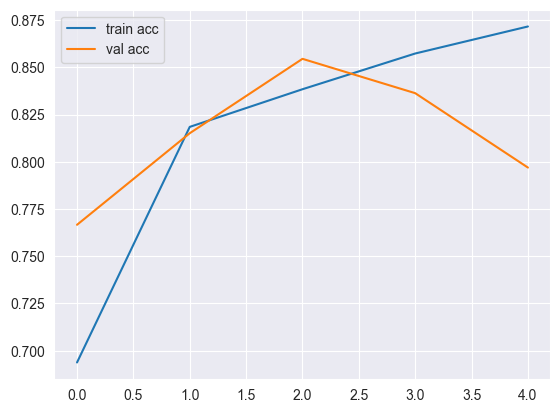

In [30]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')
import numpy as np

In [31]:
test_image = tf.keras.preprocessing.image.load_img(
    './Dataset/test/n95v/1.jpg',
    target_size=INPUT_SIZE)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
i = np.argmax(result[0])
classes = training_data.class_indices.keys()
print(classes)
list(classes)[i]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


'n95v'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.68..130.061].


TypeError: 'dict_keys' object is not subscriptable

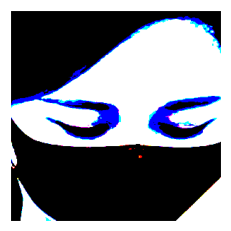

In [36]:
def plot_image(j, predictions_array, true_label, img):
    true_label, img = true_label[j], img[j]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                         100*np.max(predictions_array),
                                         classes[np.argmax(true_label)]),
               color=color)

def plot_value_array(k, predictions_array, true_label):
    true_label = true_label[k]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.argmax(true_label)].set_color('blue')

i = 1
# print(classes)
# print(classes[i])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, result, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, result[0], y_test)
plt.show()